#Practical 2

## Data Exploration
### Initialisation

Import relevant packes and data set

In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# ensure all columns shown
pd.set_option('display.max_columns', None)

# import data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train

FileNotFoundError: ignored

### Data Exploration

Look at summary of data

In [ ]:
df_train.info()

Class requires converting to Boolean

In [ ]:
df_train.Class = df_train.Class.replace({1: True, 0: False})

Get summary statistics for data

In [ ]:
df_train.describe(include = "all")

Initial comments:
 - Unlabelled predictors have undergone Principal Component Analysis (PCA)
 - All unlabelled predictors are decimal numbers
 - All unlabelled predictors include positive and negative values
 - Time and Amount are decimal numbers
 - Time and Amount are non-negative values
 - Class has 218660 0 values (legitimate) and 469 1 values (fraudulent)
 - id is not a relevant predictor

Plot histograms of data

In [ ]:
%matplotlib inline
df_train.loc[:, ~df_train.columns.isin(["id", "Class"])].hist(bins = 50, figsize = (20, 15))
plt.show()

Comments on histograms:
 - All unlabelled predictors have approximate normal distribution (due to PCA)
 - Unlabelled predictors are broadly in two categories: higher standard deviation and low standard deviation
 - The Amount predictor is strongly positively skewed
 - The Time predictor has no obvious distribution

Look at correlation values

In [ ]:
# create correlation matrix from training data
corr_matrix = df_train.corr()

"""sns.heatmap(corr_matrix,
            xticklabels = corr_matrix.columns,
            yticklabels = corr_matrix.columns)"""

cmap = sns.diverging_palette(5, 250, s = 99, sep = 1, as_cmap = True, center = "light")


def magnify():
    return [dict(selector = "th",
                props=[("font-size", "7pt")]),
           dict(selector = "td",
                props=[("padding", "0.2em 0.5em")]),
           dict(selector = "th:hover",
                props=[("font-size", "12pt")]),
           dict(selector = "tr:hover td:hover",
                props=[("max-width", "200px"),
                       ("font-size", "14pt")])
           ]
corr_matrix.style.background_gradient(cmap, axis = 1, vmin = -1)\
           .set_properties(**{"max-width": "60px", "font-size": "6pt"})\
           .set_caption("Hover to magnify")\
           .set_precision(2)\
           .set_table_styles(magnify())

Comments on correlation:
 - Highest correlations (>0.5) between **V2 and Amount**, and **V20 and Amount** 
 - High correlations (>0.3) between **V9 and V10**, **V5 and V6**, **V1 and V2**, **V5 and Amount**, **V12 and V14**, and **V21 and V22**

Plot potentially correlated variables

In [ ]:
def corr_plot(pred1, pred2):
    plt.scatter(df_train.loc[:, pred1], df_train.loc[:, pred2])
    plt.xlabel(pred1)
    plt.ylabel(pred2)
corr_fig = plt.figure(figsize=(20,5))
gs = GridSpec(nrows = 2, ncols = 4)
ax0 = corr_fig.add_subplot(gs[0, 0])
corr_plot("V2", "Amount")
ax1 = corr_fig.add_subplot(gs[0, 1])
corr_plot("V20", "Amount")
ax2 = corr_fig.add_subplot(gs[0, 2])
corr_plot("V9", "V10")
ax3 = corr_fig.add_subplot(gs[0, 3])
corr_plot("V5", "V6")
ax4 = corr_fig.add_subplot(gs[1, 0])
corr_plot("V1", "V2")
ax5 = corr_fig.add_subplot(gs[1, 1])
corr_plot("V5", "Amount")
ax6 = corr_fig.add_subplot(gs[1, 2])
corr_plot("V12", "V14")
ax7 = corr_fig.add_subplot(gs[1, 3])
corr_plot("V21", "V22")

# Forming Models

### Modelling LGBM and Logistic Regression


In [ ]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn | grep -v 'already satisfied'
!pip install lightgbm
!pip install optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgbm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read file in as cv
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Clear the maximum number of columns to be displayed, so that all will be visible.
pd.set_option('display.max_columns', None)

display(train)

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,0.836798,-0.056580,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.226546,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-1.504823,0.554039,-0.824356,-0.527267,-0.095838,-0.312519,0.642659,-0.340089,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,-0.097495,1.338869,1.391399,-0.128167,-0.081836,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219124,219124,120580.0,1.891079,-1.272908,-3.783908,-1.388939,2.012789,2.666080,0.151740,0.401934,-1.102824,0.858158,-0.280639,0.007976,-0.124950,0.914374,-0.073169,-2.309929,-0.041423,1.190526,-0.281848,-0.195703,-0.181369,-0.456538,-0.069571,0.756765,0.244479,-0.147566,-0.054725,-0.044588,198.65,0
219125,219125,120580.0,0.139724,0.948649,-2.913655,-2.184829,1.883716,-1.056824,1.725624,0.018089,-0.823494,-0.257933,-0.457534,0.516146,-0.071240,1.310799,-1.892909,-0.318780,-0.917395,0.098397,-0.195558,-0.116538,0.491469,1.478823,-0.085398,-0.091409,-1.053488,0.467570,0.358918,0.294735,24.00,0
219126,219126,120580.0,2.058343,-0.038993,-1.928553,0.330117,0.270127,-0.735664,-0.173878,0.144823,0.849289,-0.136498,0.179926,-1.769641,-3.937694,0.031346,0.028100,0.883566,0.391801,1.007789,0.303376,-0.384830,-0.306640,-0.965783,0.307799,-0.021434,-0.343989,0.181065,-0.098387,-0.044064,1.79,0
219127,219127,120580.0,2.079227,-2.162389,-1.785833,-2.804889,0.552845,4.038013,-2.155900,1.023785,-0.865242,1.536193,-0.058879,-0.885949,-0.254718,-0.425730,0.665556,-0.336634,0.301966,0.391249,0.037770,-0.190984,0.109909,0.590401,0.286621,0.675660,-0.510736,-0.090044,0.056749,-0.017126,88.00,0


Firstly, we will look at the LGBM model. 
\
The code was inspired by https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5 and https://www.kaggle.com/code/soupmonster/simple-lgbm-baseline-optuna#Optuna. 
\
We have used Optuna in order to recognise the best combination of hyperparameters.

In [ ]:
target = 'Class'
X = train.reset_index(drop = True)
test = test
features = [c for c in train.columns if c not in [ target]]

In [ ]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=71)

In [ ]:
def objective(trial):
    param_grid = {
        'objective': 'binary',
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=298),
        "max_depth": trial.suggest_int("max_depth", 6, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 90, 105),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=20),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=20),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.65),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.65, 0.85)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X[features], X[target])):
        X_train, y_train = X.loc[train_idx, features], X.loc[train_idx, target]
        X_val, y_val = X.loc[val_idx, features], X.loc[val_idx, target]

        model = lgbm.LGBMClassifier(**param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=50,
            verbose = 500)
        
        
        preds = model.predict_proba(X_val)[:,1]
        cv_scores[idx] = roc_auc_score(y_val, preds)

    return np.mean(cv_scores)

In [ ]:
from optuna.samplers import TPESampler
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
study.best_params

[I 2023-03-30 12:32:06,710] A new study created in memory with name: no-name-763aa0cb-96db-49f5-bf19-2428b718bc31
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5428338644472678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5428338644472678
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.760429929531937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.760429929531937
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5428338644472678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5428338644472678
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.760429929531937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.760429929531937
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5428338644472678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5428338644472678
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.760429929531937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.760429929531937
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5428338644472678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5428338644472678
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.760429929531937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.760429929531937
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5428338644472678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5428338644472678
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.760429929531937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.760429929531937
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-30 12:33:03,207] Trial 0 finished with value: 0.814872989519597 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1383380978084117, 'num_leaves': 1808, 'max_depth': 12, 'min_data_in_leaf': 103, 'lambda_l1': 0, 'lambda_l2': 60, 'bagging_fraction': 0.5428338644472678, 'bagging_freq': 1, 'feature_fraction': 0.760429929531937}. Best is trial 0 with value: 0.814872989519597.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.6499731796858974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499731796858974
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.7760328603894042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7760328603894042
[LightGBM] [Warning] min_data_in_leaf is set=105, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.6499731796858974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499731796858974
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.7760328603894042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7760328603894042
[LightGBM] [Warning] min_data_in_leaf is set=105, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.6499731796858974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499731796858974
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.7760328603894042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7760328603894042
[LightGBM] [Warning] min_data_in_leaf is set=105, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.6499731796858974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499731796858974
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.7760328603894042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7760328603894042
[LightGBM] [Warning] min_data_in_leaf is set=105, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.6499731796858974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499731796858974
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.7760328603894042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7760328603894042
[LightGBM] [Warning] min_data_in_leaf is set=105, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-30 12:33:41,457] Trial 1 finished with value: 0.6981651688160386 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28946567849159766, 'num_leaves': 1808, 'max_depth': 10, 'min_data_in_leaf': 105, 'lambda_l1': 80, 'lambda_l2': 100, 'bagging_fraction': 0.6499731796858974, 'bagging_freq': 1, 'feature_fraction': 0.7760328603894042}. Best is trial 0 with value: 0.814872989519597.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_war

[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5460965771258647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5460965771258647
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.7152575269456586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7152575269456586
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5460965771258647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5460965771258647
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.7152575269456586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7152575269456586
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5460965771258647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5460965771258647
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.7152575269456586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7152575269456586
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5460965771258647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5460965771258647
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.7152575269456586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7152575269456586
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5460965771258647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5460965771258647
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.7152575269456586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7152575269456586
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-30 12:34:15,759] Trial 2 finished with value: 0.6620655080696481 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2064741093786654, 'num_leaves': 2404, 'max_depth': 6, 'min_data_in_leaf': 94, 'lambda_l1': 80, 'lambda_l2': 20, 'bagging_fraction': 0.5460965771258647, 'bagging_freq': 1, 'feature_fraction': 0.7152575269456586}. Best is trial 0 with value: 0.814872989519597.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning

[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5581805282718164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5581805282718164
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.7488347423195976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7488347423195976
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0132137


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5581805282718164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5581805282718164
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.7488347423195976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7488347423195976
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0129331
[1000]	valid_0's binary_logloss: 0.0128035
[1500]	valid_0's binary_logloss: 0.0127504


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5581805282718164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5581805282718164
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.7488347423195976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7488347423195976
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0135808
[1000]	valid_0's binary_logloss: 0.0134549
[1500]	valid_0's binary_logloss: 0.0133978


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5581805282718164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5581805282718164
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.7488347423195976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7488347423195976
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0131749
[1000]	valid_0's binary_logloss: 0.0130416


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5581805282718164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5581805282718164
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.7488347423195976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7488347423195976
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0132273
[1000]	valid_0's binary_logloss: 0.0131846


[I 2023-03-30 12:37:00,745] Trial 3 finished with value: 0.8166278908347622 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03311839160739361, 'num_leaves': 2702, 'max_depth': 8, 'min_data_in_leaf': 103, 'lambda_l1': 20, 'lambda_l2': 40, 'bagging_fraction': 0.5581805282718164, 'bagging_freq': 1, 'feature_fraction': 0.7488347423195976}. Best is trial 3 with value: 0.8166278908347622.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warn

[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.6081469530242185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6081469530242185
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.702873455234831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.702873455234831
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0145958


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.6081469530242185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6081469530242185
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.702873455234831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.702873455234831
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.01445


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.6081469530242185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6081469530242185
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.702873455234831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.702873455234831
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0145797


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.6081469530242185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6081469530242185
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.702873455234831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.702873455234831
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.6081469530242185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6081469530242185
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.702873455234831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.702873455234831
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0142366


[I 2023-03-30 12:37:56,630] Trial 4 finished with value: 0.7634280890031656 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13748241032348263, 'num_leaves': 318, 'max_depth': 6, 'min_data_in_leaf': 98, 'lambda_l1': 60, 'lambda_l2': 0, 'bagging_fraction': 0.6081469530242185, 'bagging_freq': 1, 'feature_fraction': 0.702873455234831}. Best is trial 3 with value: 0.8166278908347622.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.5749104242247253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749104242247253
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.711465571218884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.711465571218884
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0154818


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.5749104242247253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749104242247253
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.711465571218884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.711465571218884
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.5749104242247253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749104242247253
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.711465571218884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.711465571218884
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.5749104242247253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749104242247253
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.711465571218884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.711465571218884
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.5749104242247253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749104242247253
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.711465571218884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.711465571218884
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0153582


[I 2023-03-30 12:38:36,815] Trial 5 finished with value: 0.6119639619601874 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2153270945117389, 'num_leaves': 1212, 'max_depth': 12, 'min_data_in_leaf': 103, 'lambda_l1': 100, 'lambda_l2': 100, 'bagging_fraction': 0.5749104242247253, 'bagging_freq': 1, 'feature_fraction': 0.711465571218884}. Best is trial 3 with value: 0.8166278908347622.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_war

[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5435101617635315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5435101617635315
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.8388100179701828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8388100179701828
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5435101617635315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5435101617635315
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.8388100179701828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8388100179701828
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5435101617635315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5435101617635315
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.8388100179701828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8388100179701828
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5435101617635315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5435101617635315
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.8388100179701828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8388100179701828
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5435101617635315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5435101617635315
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.8388100179701828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8388100179701828
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-30 12:39:09,004] Trial 6 finished with value: 0.6600183776235038 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2650935574868244, 'num_leaves': 1510, 'max_depth': 8, 'min_data_in_leaf': 90, 'lambda_l1': 80, 'lambda_l2': 20, 'bagging_fraction': 0.5435101617635315, 'bagging_freq': 1, 'feature_fraction': 0.8388100179701828}. Best is trial 3 with value: 0.8166278908347622.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5243575556705113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5243575556705113
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.8239497432793628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8239497432793628
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5243575556705113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5243575556705113
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.8239497432793628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8239497432793628
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0127158


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5243575556705113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5243575556705113
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.8239497432793628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8239497432793628
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0133614


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5243575556705113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5243575556705113
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.8239497432793628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8239497432793628
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5243575556705113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5243575556705113
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.8239497432793628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8239497432793628
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-30 12:40:11,433] Trial 7 finished with value: 0.8158648323078802 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16496043137826977, 'num_leaves': 2106, 'max_depth': 10, 'min_data_in_leaf': 100, 'lambda_l1': 20, 'lambda_l2': 60, 'bagging_fraction': 0.5243575556705113, 'bagging_freq': 1, 'feature_fraction': 0.8239497432793628}. Best is trial 3 with value: 0.8166278908347622.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_war

[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5018163820350472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5018163820350472
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.7063174248634279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7063174248634279
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0143464
[1000]	valid_0's binary_logloss: 0.0141905
[1500]	valid_0's binary_logloss: 0.0140982
[2000]	valid_0's binary_logloss: 0.0140417
[2500]	valid_0's binary_logloss: 0.0140026
[3000]	valid_0's binary_logloss: 0.0139647
[3500

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5018163820350472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5018163820350472
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.7063174248634279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7063174248634279
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0141298
[1000]	valid_0's binary_logloss: 0.0139031
[1500]	valid_0's binary_logloss: 0.0138073
[2000]	valid_0's binary_logloss: 0.0137502
[2500]	valid_0's binary_logloss: 0.0136976
[3000]	valid_0's binary_logloss: 0.013661
[3500]

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5018163820350472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5018163820350472
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.7063174248634279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7063174248634279
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0143958
[1000]	valid_0's binary_logloss: 0.0142362
[1500]	valid_0's binary_logloss: 0.0141765
[2000]	valid_0's binary_logloss: 0.0141448
[2500]	valid_0's binary_logloss: 0.0141155
[3000]	valid_0's binary_logloss: 0.0140958
[3500

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5018163820350472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5018163820350472
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.7063174248634279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7063174248634279
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0142631
[1000]	valid_0's binary_logloss: 0.0140868
[1500]	valid_0's binary_logloss: 0.0140101
[2000]	valid_0's binary_logloss: 0.0139599
[2500]	valid_0's binary_logloss: 0.0139236
[3000]	valid_0's binary_logloss: 0.013894
[3500]

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5018163820350472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5018163820350472
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.7063174248634279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7063174248634279
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0139992
[1000]	valid_0's binary_logloss: 0.0137942
[1500]	valid_0's binary_logloss: 0.0136972
[2000]	valid_0's binary_logloss: 0.0136498
[2500]	valid_0's binary_logloss: 0.0136089
[3000]	valid_0's binary_logloss: 0.0135721
[3500

[I 2023-03-30 12:48:06,665] Trial 8 finished with value: 0.7941802637633356 and parameters: {'n_estimators': 10000, 'learning_rate': 0.039732498639240374, 'num_leaves': 2404, 'max_depth': 9, 'min_data_in_leaf': 103, 'lambda_l1': 40, 'lambda_l2': 100, 'bagging_fraction': 0.5018163820350472, 'bagging_freq': 1, 'feature_fraction': 0.7063174248634279}. Best is trial 3 with value: 0.8166278908347622.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_wa

[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.5262034636312622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5262034636312622
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.7473947390786714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7473947390786714
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.5262034636312622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5262034636312622
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.7473947390786714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7473947390786714
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.5262034636312622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5262034636312622
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.7473947390786714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7473947390786714
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.5262034636312622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5262034636312622
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.7473947390786714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7473947390786714
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.5262034636312622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5262034636312622
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.7473947390786714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7473947390786714
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-30 12:48:39,785] Trial 9 finished with value: 0.7468497564866666 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2725573225064304, 'num_leaves': 1808, 'max_depth': 10, 'min_data_in_leaf': 103, 'lambda_l1': 60, 'lambda_l2': 0, 'bagging_fraction': 0.5262034636312622, 'bagging_freq': 1, 'feature_fraction': 0.7473947390786714}. Best is trial 3 with value: 0.8166278908347622.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warni

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5820535774206446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5820535774206446
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.653646186077556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.653646186077556
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0132032


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5820535774206446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5820535774206446
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.653646186077556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.653646186077556
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0129276


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5820535774206446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5820535774206446
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.653646186077556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.653646186077556
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0135694


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5820535774206446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5820535774206446
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.653646186077556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.653646186077556
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0131843


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5820535774206446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5820535774206446
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.653646186077556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.653646186077556
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0132726


[I 2023-03-30 12:51:57,323] Trial 10 finished with value: 0.8162284554559903 and parameters: {'n_estimators': 10000, 'learning_rate': 0.013153754794134095, 'num_leaves': 3000, 'max_depth': 8, 'min_data_in_leaf': 95, 'lambda_l1': 0, 'lambda_l2': 40, 'bagging_fraction': 0.5820535774206446, 'bagging_freq': 1, 'feature_fraction': 0.653646186077556}. Best is trial 3 with value: 0.8166278908347622.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warni

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5798303698076422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5798303698076422
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.6527539689690641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6527539689690641
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0130527


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5798303698076422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5798303698076422
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.6527539689690641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6527539689690641
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0128061


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5798303698076422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5798303698076422
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.6527539689690641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6527539689690641
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0133791


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5798303698076422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5798303698076422
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.6527539689690641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6527539689690641
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5798303698076422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5798303698076422
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.6527539689690641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6527539689690641
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-30 12:53:58,167] Trial 11 finished with value: 0.817162845708401 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02413061504030213, 'num_leaves': 3000, 'max_depth': 8, 'min_data_in_leaf': 94, 'lambda_l1': 0, 'lambda_l2': 40, 'bagging_fraction': 0.5798303698076422, 'bagging_freq': 1, 'feature_fraction': 0.6527539689690641}. Best is trial 11 with value: 0.817162845708401.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5772390229990488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5772390229990488
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.6575366937469832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6575366937469832
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0130234


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5772390229990488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5772390229990488
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.6575366937469832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6575366937469832
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.012813
[1000]	valid_0's binary_logloss: 0.0127241


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5772390229990488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5772390229990488
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.6575366937469832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6575366937469832
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0135025


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5772390229990488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5772390229990488
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.6575366937469832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6575366937469832
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0130471


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5772390229990488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5772390229990488
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.6575366937469832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6575366937469832
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0131602


[I 2023-03-30 12:55:36,923] Trial 12 finished with value: 0.8161852758120357 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05984096428079046, 'num_leaves': 3000, 'max_depth': 7, 'min_data_in_leaf': 93, 'lambda_l1': 20, 'lambda_l2': 40, 'bagging_fraction': 0.5772390229990488, 'bagging_freq': 1, 'feature_fraction': 0.6575366937469832}. Best is trial 11 with value: 0.817162845708401.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warn

[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5892625473812552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5892625473812552
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.8001449118798184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8001449118798184
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0130479


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5892625473812552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5892625473812552
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.8001449118798184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8001449118798184
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0127927
[1000]	valid_0's binary_logloss: 0.0127127


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5892625473812552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5892625473812552
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.8001449118798184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8001449118798184
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0134815


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5892625473812552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5892625473812552
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.8001449118798184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8001449118798184
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0130496


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5892625473812552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5892625473812552
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.8001449118798184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8001449118798184
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-30 12:57:17,796] Trial 13 finished with value: 0.8150958539025048 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08054717952715812, 'num_leaves': 3000, 'max_depth': 8, 'min_data_in_leaf': 97, 'lambda_l1': 20, 'lambda_l2': 60, 'bagging_fraction': 0.5892625473812552, 'bagging_freq': 1, 'feature_fraction': 0.8001449118798184}. Best is trial 11 with value: 0.817162845708401.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warn

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.560370610228302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.560370610228302
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.7381997588438164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7381997588438164
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.560370610228302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.560370610228302
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.7381997588438164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7381997588438164
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.560370610228302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.560370610228302
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.7381997588438164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7381997588438164
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.560370610228302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.560370610228302
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.7381997588438164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7381997588438164
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.560370610228302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.560370610228302
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.7381997588438164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7381997588438164
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-30 12:58:19,659] Trial 14 finished with value: 0.8175410504023979 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08687867411393084, 'num_leaves': 914, 'max_depth': 7, 'min_data_in_leaf': 91, 'lambda_l1': 0, 'lambda_l2': 80, 'bagging_fraction': 0.560370610228302, 'bagging_freq': 1, 'feature_fraction': 0.7381997588438164}. Best is trial 14 with value: 0.8175410504023979.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6022924967750453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6022924967750453
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.6773984790032574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6773984790032574
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6022924967750453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6022924967750453
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.6773984790032574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6773984790032574
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6022924967750453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6022924967750453
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.6773984790032574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6773984790032574
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6022924967750453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6022924967750453
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.6773984790032574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6773984790032574
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6022924967750453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6022924967750453
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.6773984790032574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6773984790032574
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-30 12:59:20,485] Trial 15 finished with value: 0.8190608316795235 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08714129165865309, 'num_leaves': 616, 'max_depth': 7, 'min_data_in_leaf': 90, 'lambda_l1': 0, 'lambda_l2': 80, 'bagging_fraction': 0.6022924967750453, 'bagging_freq': 1, 'feature_fraction': 0.6773984790032574}. Best is trial 15 with value: 0.8190608316795235.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warni

[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.60980354696533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.60980354696533
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.6929084725923613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6929084725923613
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0138354
[1000]	valid_0's binary_logloss: 0.0137411


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.60980354696533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.60980354696533
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.6929084725923613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6929084725923613
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.013504
[1000]	valid_0's binary_logloss: 0.0133818
[1500]	valid_0's binary_logloss: 0.0133381
[2000]	valid_0's binary_logloss: 0.0133011
[2500]	valid_0's binary_logloss: 0.0132643
[3000]	valid_0's binary_logloss: 0.0132515


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.60980354696533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.60980354696533
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.6929084725923613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6929084725923613
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0140232
[1000]	valid_0's binary_logloss: 0.0139444
[1500]	valid_0's binary_logloss: 0.013904
[2000]	valid_0's binary_logloss: 0.0138746


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.60980354696533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.60980354696533
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.6929084725923613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6929084725923613
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0137414
[1000]	valid_0's binary_logloss: 0.0136484
[1500]	valid_0's binary_logloss: 0.0136009
[2000]	valid_0's binary_logloss: 0.0135702


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.60980354696533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.60980354696533
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.6929084725923613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6929084725923613
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0134649
[1000]	valid_0's binary_logloss: 0.0133837
[1500]	valid_0's binary_logloss: 0.0133355
[2000]	valid_0's binary_logloss: 0.013313
[2500]	valid_0's binary_logloss: 0.01329
[3000]	valid_0's binary_logloss: 0.0132655


[I 2023-03-30 13:02:35,358] Trial 16 finished with value: 0.7999892483790383 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09336475962655091, 'num_leaves': 616, 'max_depth': 7, 'min_data_in_leaf': 90, 'lambda_l1': 40, 'lambda_l2': 80, 'bagging_fraction': 0.60980354696533, 'bagging_freq': 1, 'feature_fraction': 0.6929084725923613}. Best is trial 15 with value: 0.8190608316795235.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6061089605427359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6061089605427359
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.6843017900177504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6843017900177504
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6061089605427359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6061089605427359
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.6843017900177504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6843017900177504
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6061089605427359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6061089605427359
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.6843017900177504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6843017900177504
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6061089605427359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6061089605427359
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.6843017900177504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6843017900177504
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6061089605427359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6061089605427359
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.6843017900177504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6843017900177504
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-30 13:03:36,894] Trial 17 finished with value: 0.8174401111380284 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09026167355446713, 'num_leaves': 914, 'max_depth': 7, 'min_data_in_leaf': 92, 'lambda_l1': 0, 'lambda_l2': 80, 'bagging_fraction': 0.6061089605427359, 'bagging_freq': 1, 'feature_fraction': 0.6843017900177504}. Best is trial 15 with value: 0.8190608316795235.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warni

[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5623591492476309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5623591492476309
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.7300013022845665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7300013022845665
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0138874
[1000]	valid_0's binary_logloss: 0.0137903
[1500]	valid_0's binary_logloss: 0.013721


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5623591492476309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5623591492476309
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.7300013022845665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7300013022845665
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0136209
[1000]	valid_0's binary_logloss: 0.0134812
[1500]	valid_0's binary_logloss: 0.0134251
[2000]	valid_0's binary_logloss: 0.0133838
[2500]	valid_0's binary_logloss: 0.013358
[3000]	valid_0's binary_logloss: 0.0133383
[3500]	val

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5623591492476309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5623591492476309
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.7300013022845665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7300013022845665
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.014063
[1000]	valid_0's binary_logloss: 0.01398
[1500]	valid_0's binary_logloss: 0.01394
[2000]	valid_0's binary_logloss: 0.0139025


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5623591492476309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5623591492476309
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.7300013022845665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7300013022845665
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.01385
[1000]	valid_0's binary_logloss: 0.0137317
[1500]	valid_0's binary_logloss: 0.013675


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5623591492476309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5623591492476309
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.7300013022845665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7300013022845665
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	valid_0's binary_logloss: 0.0135386
[1000]	valid_0's binary_logloss: 0.0134429
[1500]	valid_0's binary_logloss: 0.0133926
[2000]	valid_0's binary_logloss: 0.0133673
[2500]	valid_0's binary_logloss: 0.0133354
[3000]	valid_0's binary_logloss: 0.0133048
[3500]	va

[I 2023-03-30 13:07:03,232] Trial 18 finished with value: 0.7980259067610139 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11193164276984491, 'num_leaves': 20, 'max_depth': 6, 'min_data_in_leaf': 91, 'lambda_l1': 40, 'lambda_l2': 80, 'bagging_fraction': 0.5623591492476309, 'bagging_freq': 1, 'feature_fraction': 0.7300013022845665}. Best is trial 15 with value: 0.8190608316795235.
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warni

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6309027973564789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6309027973564789
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.67679384953785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.67679384953785
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6309027973564789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6309027973564789
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.67679384953785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.67679384953785
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6309027973564789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6309027973564789
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.67679384953785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.67679384953785
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6309027973564789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6309027973564789
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.67679384953785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.67679384953785
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6309027973564789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6309027973564789
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.67679384953785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.67679384953785
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-30 13:08:18,816] Trial 19 finished with value: 0.8196486370060455 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06349713638392787, 'num_leaves': 914, 'max_depth': 9, 'min_data_in_leaf': 96, 'lambda_l1': 0, 'lambda_l2': 80, 'bagging_fraction': 0.6309027973564789, 'bagging_freq': 1, 'feature_fraction': 0.67679384953785}. Best is trial 19 with value: 0.8196486370060455.


{'n_estimators': 10000,
 'learning_rate': 0.06349713638392787,
 'num_leaves': 914,
 'max_depth': 9,
 'min_data_in_leaf': 96,
 'lambda_l1': 0,
 'lambda_l2': 80,
 'bagging_fraction': 0.6309027973564789,
 'bagging_freq': 1,
 'feature_fraction': 0.67679384953785}

In [ ]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.81815
	Best params:
		n_estimators: 10000
		learning_rate: 0.012657044319814941
		num_leaves: 914
		max_depth: 12
		min_data_in_leaf: 96
		lambda_l1: 20
		lambda_l2: 60
		bagging_fraction: 0.5005025736365822
		bagging_freq: 1
		feature_fraction: 0.7454149740785743


We have opted to analyse our model with the ROC AUC metric. This is because, in heavily imbalanced datasets, accuracy can easily be a high value by just stating 'non-fraud' for all data.
\
We use our best hyperparameters in our final model below.

In [ ]:

n=10
cv = StratifiedKFold(n,shuffle=True, random_state=42)
test_preds = []

all_scores = []
for i,(train_idx,val_idx) in enumerate(cv.split(train[features],train[target])):
    X_train, y_train = train.loc[train_idx, features],train.loc[train_idx, target]
    X_val, y_val = train.loc[val_idx, features],train.loc[val_idx, target] 
    params = study.best_params  
    # params={'objective': 'binary',
    #          'metric': 'auc',
    #          'lambda_l1': 0, 
    #          'lambda_l2': 80,
    #          'num_leaves': 318,
    #          'feature_fraction': 0.7436227064576392,
    #          'bagging_fraction': 0.5217811575714206,
    #          'bagging_freq': 1,
    #          'min_data_in_leaf': 101,
    #          'max_depth': 10,
    #          'num_iterations': 10000,
    #          'learning_rate':0.012748151486204224}
    
    model = lgbm.LGBMClassifier(**params)
    model.fit(X_train,
              y_train,
              eval_set = [(X_val,y_val)],
              early_stopping_rounds=50,
              verbose=500)
    
    y_pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val,y_pred)
    all_scores.append(score)
    
    test_pred = model.predict_proba(test[features])[:,1]
    test_preds.append(test_pred)
    print(f'=== Fold {i} ROC AUC Score {score} ===')
print(f'=== Average ROC AUC Score {np.mean(all_scores)} ===')

NameError: ignored

The LGBM model gave an average ROC AUC Score 0.8052436998950719. 0.82 in a previous run through.
\
LGBM_preds gives the average value for each transaction from across all 10 folds.

In [ ]:
LGBM_preds = np.array(test_preds).mean(axis =0)
LGBM_preds

array([0.00184607, 0.00174901, 0.00153905, ..., 0.00173669, 0.00152854,
       0.0017735 ])

Submission code to Kaggle:
\
submission1 = pd.read_csv('C:content/sample_submission.csv')
\
sub_preds = np.vstack(LGBM_preds)
\
submission1['Class'] = sub_preds
\
submission1.to_csv("submission.csv", index=False)

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: fit_intercept


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: fit_intercept


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: fit_intercept


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: fit_intercept


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: fit_intercept


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: fit_intercept


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: fit_intercept


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: fit_intercept


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: fit_intercept


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: fit_intercept


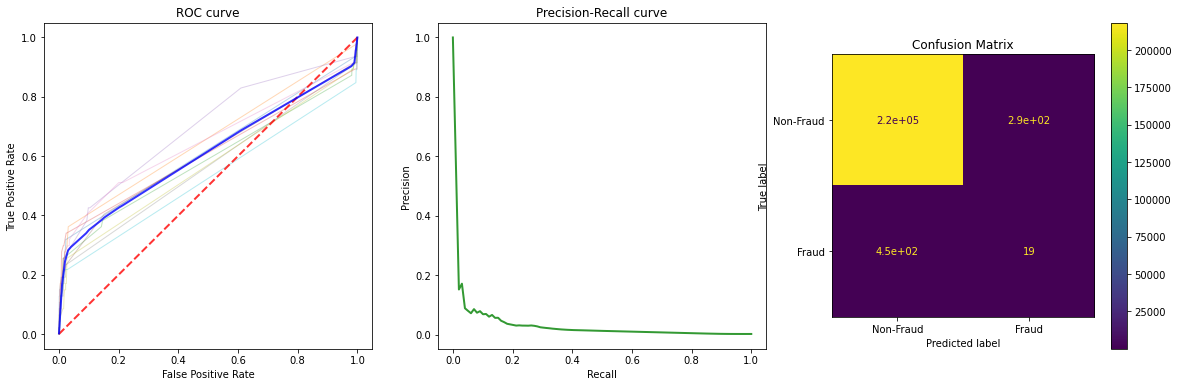

In [ ]:

# Initialize lists to store scores and curves for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
tprs = []
precisions = []
recalls = []
mean_fpr = np.linspace(0, 1, 100)
sum_conf_mat = np.zeros((2, 2))
recall_grid = np.linspace(0, 1, 100)
mean_precision = np.zeros_like(recall_grid)

# LGBM model's parameters
params = study.best_params
# params={'objective': 'binary',
#           'metric': 'auc',
#           'lambda_l1': 0, 
#           'lambda_l2': 80,
#           'num_leaves': 318,
#           'feature_fraction': 0.7436227064576392,
#           'bagging_fraction': 0.5217811575714206,
#           'bagging_freq': 1,
#           'min_data_in_leaf': 101,
#           'max_depth': 10,
#           'num_iterations': 10000,
#           'learning_rate':0.012748151486204224}

model = lgbm.LGBMClassifier(**params)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# ROC curve and Precision-Recall curve
for i, (train_idx, val_idx) in enumerate(cv.split(train[features], train[target])):
    X_train, y_train = train.loc[train_idx, features], train.loc[train_idx, target]
    X_val, y_val = train.loc[val_idx, features], train.loc[val_idx, target]

    model.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_val, y_val)], verbose=500)
    
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calculate metrics for each fold
    accuracy_scores.append(accuracy_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred))
    recall_scores.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_pred_proba))

    # Compute ROC curve and area under the curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    ax1.plot(fpr, tpr, lw=1, alpha=0.3)


    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    precisions.append(precision)
    recalls.append(recall)
    # Interpolate precision values for the current fold
    f_interp = interp1d(recall, precision, bounds_error=False, fill_value=0)
    mean_precision += f_interp(recall_grid)
    # Compute confusion matrix
    conf_mat = confusion_matrix(y_val, y_pred)
    sum_conf_mat += conf_mat
  
# Average the interpolated precision values
mean_precision /= len(precisions)

# Plot ROC curve
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
ax1.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC curve')


# Plot Precision-Recall curve
ax2.plot(recall_grid, mean_precision, color='g', lw=2, alpha=0.8)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall curve')

# Plot confusion matrix
ConfusionMatrixDisplay(sum_conf_mat, display_labels=['Non-Fraud', 'Fraud']).plot(ax=ax3)
ax3.set_title('Confusion Matrix')

plt.show()





In [ ]:
# Calculate average scores
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)
average_roc_auc = np.mean(roc_auc_scores)

# Print average scores
print(f"Average accuracy: {average_accuracy:.5f}")
print(f"Average precision: {average_precision:.5f}")
print(f"Average recall: {average_recall:.5f}")
print(f"Average F1-score: {average_f1:.5f}")
print(f"Average ROC AUC score: {average_roc_auc:.5f}")



Average accuracy: 0.99664
Average precision: 0.06287
Average recall: 0.04043
Average F1-score: 0.04900
Average ROC AUC score: 0.60744


The Logistic Regression code was inspired by https://www.kaggle.com/code/soupmonster/simple-lgbm-baseline-optuna#Optuna. 
\
We follow a very similar framework as used in the LGBM model.

In [ ]:
# https://towardsdatascience.com/tuning-the-hyperparameters-of-your-machine-learning-model-using-gridsearchcv-7fc2bb76ff27
# https://www.kaggle.com/code/yus002/logistic-regression-optuna-tuning

def objective(trial):
    param_grid = {
        'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_loguniform("C", 1e-2, 1),
        'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
         'random_state' : trial.suggest_categorical('random_state' , [0, 42, 2021, 555]),
        'solver' : trial.suggest_categorical('solver' , ['lbfgs','liblinear']),
        "n_jobs" : -1
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X[features], X[target])):
        X_train, y_train = X.loc[train_idx, features], X.loc[train_idx, target]
        X_val, y_val = X.loc[val_idx, features], X.loc[val_idx, target]

        model = LogisticRegression(**param_grid)
        model.fit(
            X_train,
            y_train)
        
    y_pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val,y_pred)
    all_scores.append(score)
    
    test_pred = model.predict_proba(test[features])[:,1]
    test_preds.append(test_pred)

    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
study.best_params

[I 2023-03-28 17:52:28,731] A new study created in memory with name: no-name-5a1387b6-c666-4ea4-855b-0da66c1d9926
<ipython-input-19-9977d60e525c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
<ipython-input-19-9977d60e525c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'C' : trial.suggest_loguniform("C", 1e-2, 1),
[I 2023-03-28 17:53:03,642] Trial 0 finished with value: 4.1 and parameters: {'tol': 0.0006802772458400531, 'C': 0.5982349364987448, 'fit_intercept': False, 'random_state': 42, 'solver': 'lbfgs'}. Best is trial 0 with value: 4.1.
<ipython-input-19-9977d60e525c>:6: FutureWarning: s

{'tol': 0.0006802772458400531,
 'C': 0.5982349364987448,
 'fit_intercept': False,
 'random_state': 42,
 'solver': 'lbfgs'}

In [ ]:
n=10
cv = StratifiedKFold(n,shuffle=True, random_state=42)
test_preds = []

all_scores = []
for i,(train_idx,val_idx) in enumerate(cv.split(train[features],train[target])):
    X_train, y_train = train.loc[train_idx, features],train.loc[train_idx, target]
    X_val, y_val = train.loc[val_idx, features],train.loc[val_idx, target]   
    params={'tol': 0.0005043467619224905,
            'C': 0.03956628721486797,
            'fit_intercept': False,
            'random_state': 44,
            'solver': 'liblinear'}
    
    model = LogisticRegression(**params)
    model.fit(X_train,
              y_train)
    
    y_pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val,y_pred)
    all_scores.append(score)
    
    test_pred = model.predict_proba(test[features])[:,1]
    test_preds.append(test_pred)
    print(f'=== Fold {i} ROC AUC Score {score} ===')
print(f'=== Average ROC AUC Score {np.mean(all_scores)} ===')

=== Fold 0 ROC AUC Score 0.5472627279113984 ===
=== Fold 1 ROC AUC Score 0.510961348717819 ===
=== Fold 2 ROC AUC Score 0.5324276881819827 ===
=== Fold 3 ROC AUC Score 0.5559111493409569 ===
=== Fold 4 ROC AUC Score 0.557071991686306 ===
=== Fold 5 ROC AUC Score 0.52369947708577 ===
=== Fold 6 ROC AUC Score 0.5703958929728656 ===
=== Fold 7 ROC AUC Score 0.5963411572615407 ===
=== Fold 8 ROC AUC Score 0.5708775501069375 ===
=== Fold 9 ROC AUC Score 0.561432480046449 ===
=== Average ROC AUC Score 0.5526381463312025 ===


Logistic Regression has an average ROC AUC Score 0.5526381463312025. This is lower than our LGBM model.

In [ ]:
logreg_preds = np.array(test_preds).mean(axis =0)
logreg_preds

array([8.68985511e-06, 6.44350929e-07, 1.08148853e-05, ...,
       4.93152012e-06, 2.45819544e-08, 2.66223826e-06])

[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] 

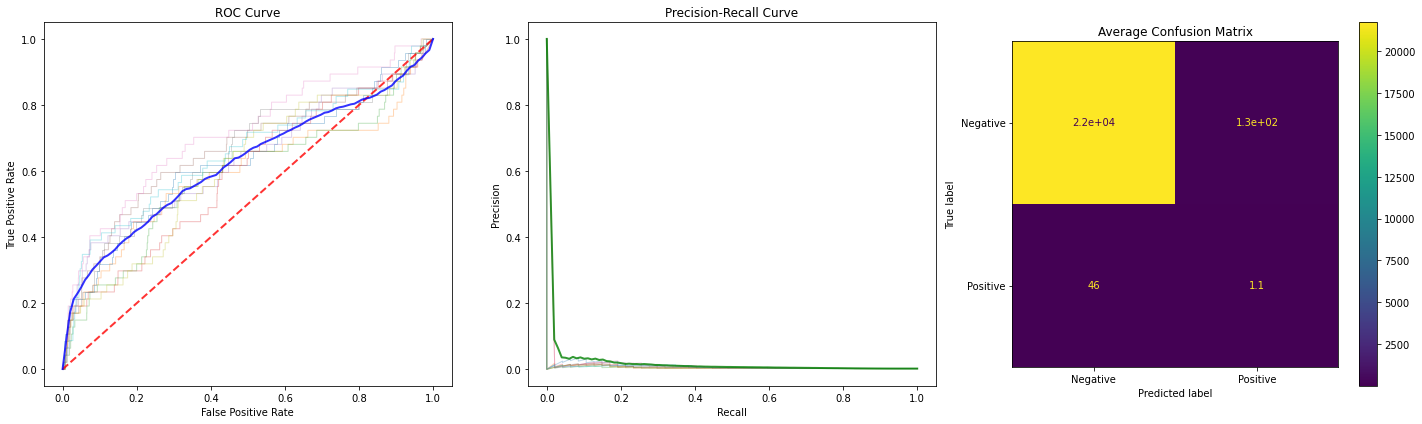

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.interpolate import interp1d
confusion_matrices = []

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# ROC curve and Precision-Recall curve
for i, (train_idx, val_idx) in enumerate(cv.split(train[features], train[target])):
    X_train, y_train = train.loc[train_idx, features], train.loc[train_idx, target]
    X_val, y_val = train.loc[val_idx, features], train.loc[val_idx, target]

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calculate metrics for each fold
    accuracy_scores.append(accuracy_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred))
    recall_scores.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_pred_proba))

    # Compute ROC curve and area under the curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    ax1.plot(fpr, tpr, lw=1, alpha=0.3)

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    precisions.append(precision)
    recalls.append(recall)
    ax2.plot(recall, precision, lw=1, alpha=0.3)

    cm = confusion_matrix(y_val, y_pred)
    confusion_matrices.append(cm)

mean_cm = np.mean(confusion_matrices, axis=0)


# ROC curve
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
ax1.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')

# Precision-Recall curve
interp_recall = np.linspace(0, 1, 100)
interp_precisions = []

for recall, precision in zip(recalls, precisions):
    f = interp1d(recall, precision, kind='linear', fill_value=(0, 1), bounds_error=False)
    interp_precisions.append(f(interp_recall))

mean_precision = np.mean(interp_precisions, axis=0)
ax2.plot(interp_recall, mean_precision, color='g', lw=2, alpha=0.8)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')

# Confusion Matrix
# cm = confusion_matrix(y_val, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
# disp.plot(ax=ax3)
# ax3.set_title('Confusion Matrix')

mean_disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm, display_labels=['Negative', 'Positive'])
mean_disp.plot(ax=ax3)
ax3.set_title('Average Confusion Matrix')


plt.tight_layout()
plt.show()


In [ ]:
# Print average scores
print('Average Accuracy:', np.mean(accuracy_scores))
print('Average Precision:', np.mean(precision_scores))
print('Average Recall:', np.mean(recall_scores))
print('Average F1 Score:', np.mean(f1_scores))
print('Average ROC AUC Score:', np.mean(roc_auc_scores))

Average Accuracy: 0.9936445382847338
Average Precision: 0.026762254101897247
Average Recall: 0.029108849830403946
Average F1 Score: 0.02479324500914178
Average ROC AUC Score: 0.6229143858287008


### Modelling Decision Tree and Random Forest

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import sklearn.tree as tree
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
# Read the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Clear the maximum number of columns to be displayed, so that all will be visible.
pd.set_option('display.max_columns', None)
display(train)

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,0.836798,-0.056580,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.226546,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-1.504823,0.554039,-0.824356,-0.527267,-0.095838,-0.312519,0.642659,-0.340089,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,-0.097495,1.338869,1.391399,-0.128167,-0.081836,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219124,219124,120580.0,1.891079,-1.272908,-3.783908,-1.388939,2.012789,2.666080,0.151740,0.401934,-1.102824,0.858158,-0.280639,0.007976,-0.124950,0.914374,-0.073169,-2.309929,-0.041423,1.190526,-0.281848,-0.195703,-0.181369,-0.456538,-0.069571,0.756765,0.244479,-0.147566,-0.054725,-0.044588,198.65,0
219125,219125,120580.0,0.139724,0.948649,-2.913655,-2.184829,1.883716,-1.056824,1.725624,0.018089,-0.823494,-0.257933,-0.457534,0.516146,-0.071240,1.310799,-1.892909,-0.318780,-0.917395,0.098397,-0.195558,-0.116538,0.491469,1.478823,-0.085398,-0.091409,-1.053488,0.467570,0.358918,0.294735,24.00,0
219126,219126,120580.0,2.058343,-0.038993,-1.928553,0.330117,0.270127,-0.735664,-0.173878,0.144823,0.849289,-0.136498,0.179926,-1.769641,-3.937694,0.031346,0.028100,0.883566,0.391801,1.007789,0.303376,-0.384830,-0.306640,-0.965783,0.307799,-0.021434,-0.343989,0.181065,-0.098387,-0.044064,1.79,0
219127,219127,120580.0,2.079227,-2.162389,-1.785833,-2.804889,0.552845,4.038013,-2.155900,1.023785,-0.865242,1.536193,-0.058879,-0.885949,-0.254718,-0.425730,0.665556,-0.336634,0.301966,0.391249,0.037770,-0.190984,0.109909,0.590401,0.286621,0.675660,-0.510736,-0.090044,0.056749,-0.017126,88.00,0


In [ ]:
# Generate our feature set and target set, and get rid of id from feature set
X = train.loc[:, 'Time':'Amount']
y = train.loc[:, 'Class']

In [ ]:
print('Shape of X training set {}'.format(X.shape), '&','Size of y training set {}'.format(y.shape))

Shape of X training set (219129, 30) & Size of y training set (219129,)


In [ ]:
# In order to test accuracy score, split the train set further. 
# If it is good enough we apply it to our assigned test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42, max_depth = 3, min_samples_leaf = 5)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9975357093962488


The accuracy score is too high, and it might be because the classes are imbalanced. When a classifier that always predicts the majority class, it can achieve high accuracy even if it fails to correctly predict any examples from the minority class. In this case, other metrics such as precision, recall, F1-score or ROC AUC score may be more appropriate.

In [ ]:
# Compute ROC AOC score
from sklearn.metrics import roc_auc_score
y_pred_prob = clf.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC AUC score:", roc_auc)

ROC AUC score: 0.5269740492921959


The ROC AUC score ranges from 0.0 to 1.0, with a score of 1.0 indicating perfect classification performance and a score of 0.5 indicating random guessing. In this case, oue ROC AUC score indicates our classification performance is not efficient.

In [ ]:
# Predict Assigned Testing Set
X_AssignedTest = test.loc[:, 'Time':'Amount']

In [ ]:
# y_predAssigned is our result for the real test set.
y_predAssigned = clf.predict(X_test)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.17333333333333334
Recall: 0.033942558746736295
F1 Score: 0.056768558951965066


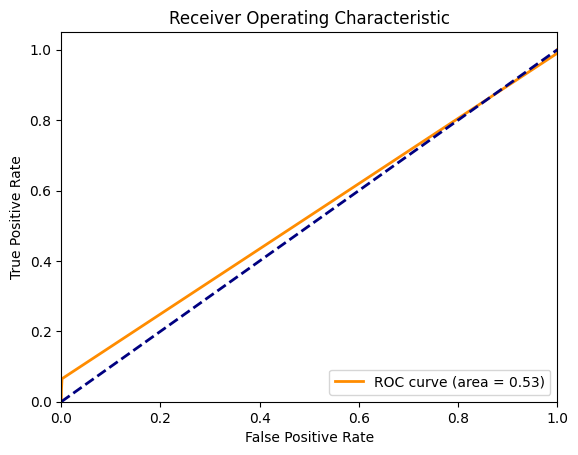

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


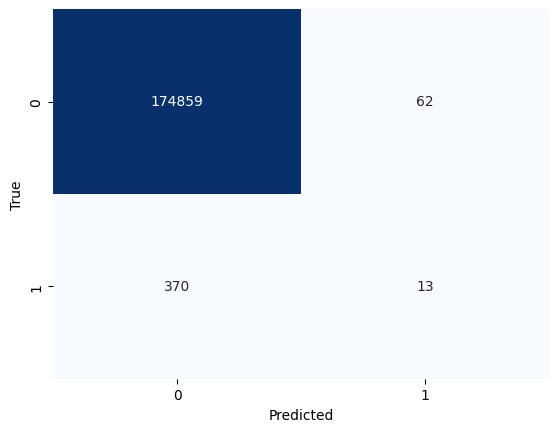

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Modelling Random Forest




In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [ ]:
# Deifine the random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [ ]:
# Fit the random forest to the training data
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate the random forest on the test data
score = rf.score(X_test, y_test)
print("Test score:", score)

Test score: 0.9978152238397299


In [ ]:
# Compute ROC AOC score
from sklearn.metrics import roc_auc_score
y_pred_prob = rf.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC AUC score:", roc_auc)

ROC AUC score: 0.6879169384976968


The ROC AUC score is exactly same with the once obtained through decision tree.
It might suggest that decision tree and random forest are essentially similar mechanisms for classification. 

In [ ]:
# Obtain feature importances
importances = rf.feature_importances_

In [ ]:
# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

In [ ]:
# Print the feature ranking
print("Feature ranking")
for f in range(X_train.shape[1]):
    print("%d.feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking
1.feature 17 (0.053526)
2.feature 14 (0.045437)
3.feature 16 (0.040509)
4.feature 26 (0.040349)
5.feature 9 (0.039922)
6.feature 10 (0.039351)
7.feature 8 (0.038587)
8.feature 6 (0.038475)
9.feature 12 (0.035266)
10.feature 19 (0.034523)
11.feature 21 (0.033882)
12.feature 22 (0.033074)
13.feature 1 (0.033058)
14.feature 15 (0.032987)
15.feature 25 (0.032730)
16.feature 13 (0.032501)
17.feature 0 (0.032478)
18.feature 2 (0.031333)
19.feature 4 (0.031330)
20.feature 24 (0.031127)
21.feature 3 (0.030804)
22.feature 18 (0.030032)
23.feature 5 (0.030029)
24.feature 11 (0.028907)
25.feature 28 (0.028712)
26.feature 7 (0.027684)
27.feature 29 (0.025738)
28.feature 20 (0.025437)
29.feature 23 (0.021759)
30.feature 27 (0.020455)


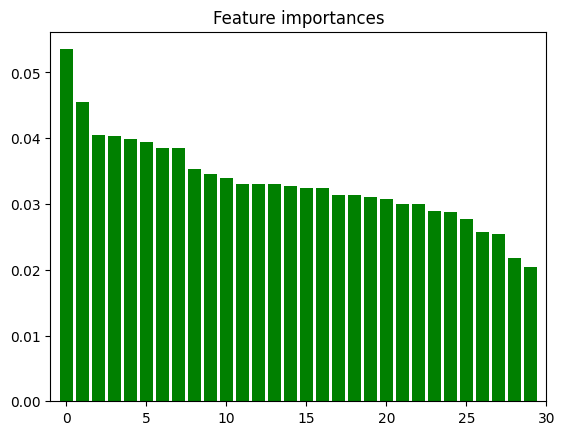

In [ ]:
# Sort the feature importances in descending order
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="g", align="center")
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
# Compute ROC AUC score
from sklearn.metrics import roc_auc_score
y_pred_prob = rf.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC AUC score:", roc_auc)


ROC AUC score: 0.6879169384976968


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions
y_pred = rf.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.9978152238397299
Precision: 0.0
Recall: 0.0
F1-score: 0.0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


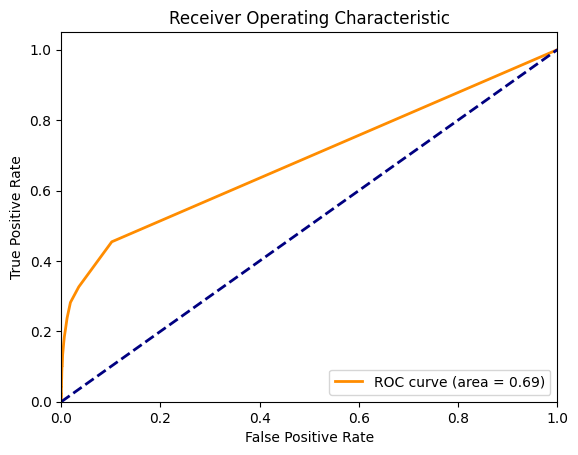

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



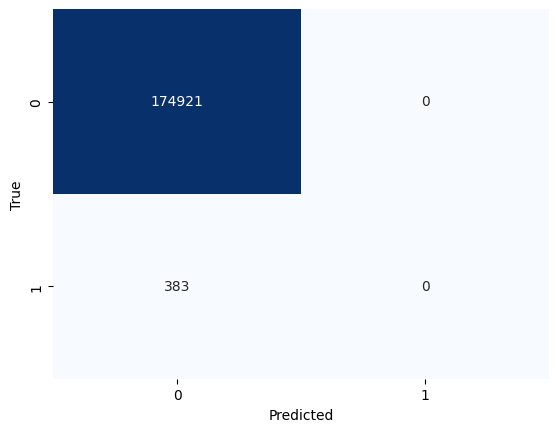

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



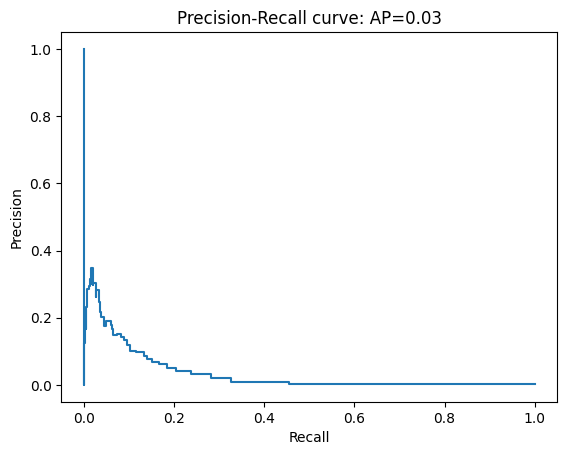

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()
